In [ ]:
!pip install category_encoders # instalacja, bo nie ma domyślnie

     |████████████████████████████████| 81kB 4.4MB/s 


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error


In [ ]:
df_raw = pd.read_csv("https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1")

# Informacje o ramce danych

In [ ]:
df_raw

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420015,420015,2016-04-03 20:27:13,6099625607,"['RTV i AGD', 'Sprzęt audio dla domu', 'Odtwar...",0,0,iwona7012,180.00,0,0,0,176,Kraśnik,RTV i AGD
420016,420016,2016-04-03 22:35:02,6099634607,"['Uroda', 'Makijaż', 'Oczy', 'Tusze do rzęs']",1,1,Dolce_Cosmetics,14.99,1,2,0,34851,Dzierżoniów,Uroda
420017,420017,2016-04-03 22:38:57,6099780407,"['Odzież, Obuwie, Dodatki', 'Przebrania, kosti...",1,1,pewex4all,5.99,1,470,0,983,Supraśl,"Odzież, Obuwie, Dodatki"
420018,420018,2016-04-03 22:44:17,6099801007,"['Dla Dzieci', 'Rowery i pojazdy', 'Rowery bie...",1,0,kostasia,200.00,0,0,0,163,Poznań,Dla Dzieci


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

# Zadanie 1a
TargetEncoding zmiennej "it_location"

In [ ]:
target_enc = ce.target_encoder.TargetEncoder(cols=["it_location"])
target_enc = target_enc.fit(df_raw, df_raw["price"])
df_loc_enc = target_enc.transform(df_raw)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


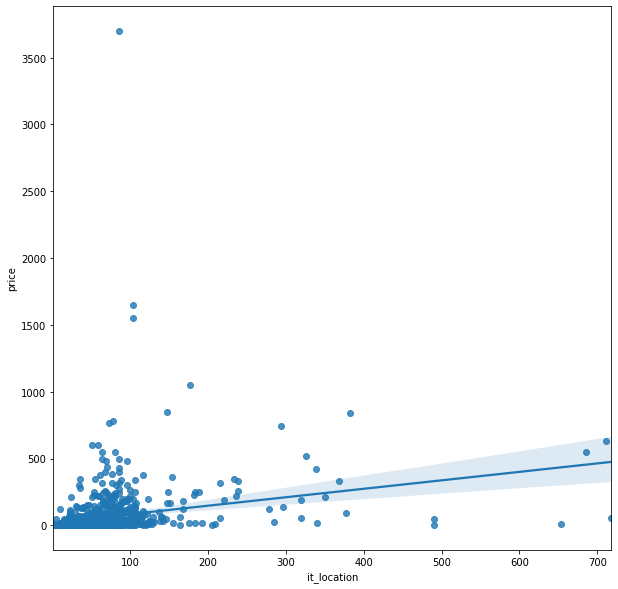

In [ ]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_loc_enc.sample(n=1000, random_state=33), x="it_location", y="price")
plt.show()

Dużo odstające wartości, warto je usunąć do wizualizacji. Dodatkowo warto wziąć próbkę, 400 tysięcy to sporo kropek na wykresie.

In [ ]:
q_low_loc = df_loc_enc["it_location"].quantile(0.05)
q_high_loc = df_loc_enc["it_location"].quantile(0.95)

q_low_price = df_loc_enc["price"].quantile(0.05)
q_high_price = df_loc_enc["price"].quantile(0.95)

df_plot = df_loc_enc[(q_low_loc < df_loc_enc["it_location"]) & (df_loc_enc["it_location"] < q_high_loc) &
                     (q_low_price < df_loc_enc["price"]) & (df_loc_enc["price"] < q_high_price)]

df_plot = df_plot.sample(n=1000, random_state=44)

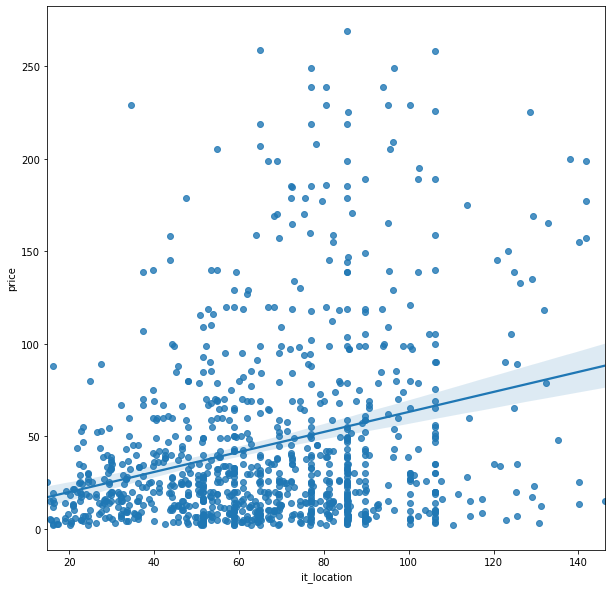

In [ ]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_plot, x="it_location", y="price")
plt.show()

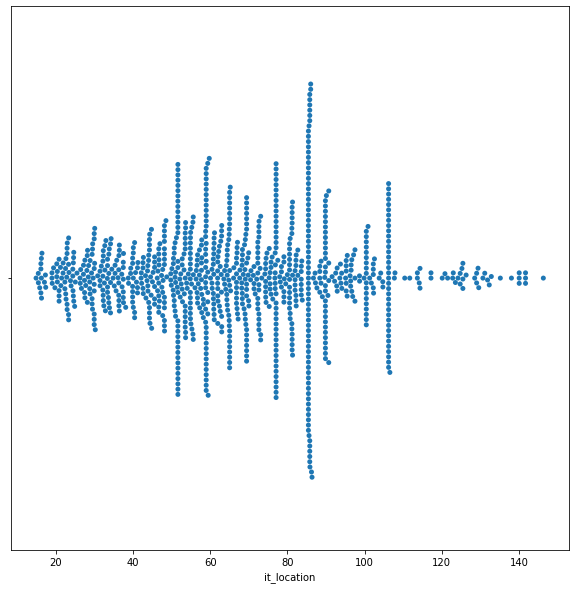

In [ ]:
plt.figure(figsize=(10,10))
sns.swarmplot(data=df_plot, x="it_location")
plt.show()

Kodowanie kategorii sposobem TargetEncoding

Plusy sposobu:

* Ładnie pasuje do regresji - liczby rzeczywiste do liczb rzeczywistych
* Dobry dla zmiennej o dużej liczbie unikatowych kategorii.
* Prosty i lekki - tylko jedna liczba rzeczywista na wiersz. 

Minusy sposobu:

* Tracimy informację o rozkładzie targetu względem zmiennych kateogrycznych. 
* W szczególności branie średniej może być czułe na wartości odstające.
* Przy małej liczbie kategorii zbytnio spłaszcza dane.


# Zadanie 1b
Encoding zmiennej "main_category" na 3 sposoby

In [ ]:
oh_encoder = ce.OneHotEncoder(cols=["main_category"])
df_oh = oh_encoder.fit_transform(df_raw)
df_oh.insert(13, "main_target", df_raw.main_category)
df_oh.iloc[:, 13:]

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,main_target,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,main_category_9,main_category_10,main_category_11,main_category_12,main_category_13,main_category_14,main_category_15,main_category_16,main_category_17,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25,main_category_26,main_category_27
0,Komputery,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Odzież, Obuwie, Dodatki",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dom i Ogród,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Książki i Komiksy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Odzież, Obuwie, Dodatki",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420015,RTV i AGD,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
420016,Uroda,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
420017,"Odzież, Obuwie, Dodatki",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
420018,Dla Dzieci,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
h_encoder = ce.HashingEncoder(cols=["main_category"])
#df_h = h_encoder.fit_transform(df_raw) # nie działa - zbyt długi czas wykonania
df_h = h_encoder.fit_transform(df_raw.head(1000)) # biorę head dla tysiąca wierszy, aby zobaczyć jak wygląda
df_h.insert(0, "main_category", df_raw.head(1000).main_category)
df_h.iloc[:, :9]

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,main_category,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,Komputery,0,0,0,0,0,0,1,0
1,"Odzież, Obuwie, Dodatki",0,0,1,0,0,0,0,0
2,Dom i Ogród,0,0,0,0,0,0,1,0
3,Książki i Komiksy,0,0,1,0,0,0,0,0
4,"Odzież, Obuwie, Dodatki",0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
995,Dom i Ogród,0,0,0,0,0,0,1,0
996,"Odzież, Obuwie, Dodatki",0,0,1,0,0,0,0,0
997,Książki i Komiksy,0,0,1,0,0,0,0,0
998,Dom i Ogród,0,0,0,0,0,0,1,0


In [ ]:
cb_encoder = ce.CatBoostEncoder(cols=["main_category"])
df_cb = cb_encoder.fit_transform(df_raw, df_raw["price"])
df_cb.insert(13, "main_category_original", df_raw.main_category)
df_cb.iloc[:, -2:]

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,main_category_original,main_category
0,Komputery,76.811350
1,"Odzież, Obuwie, Dodatki",76.811350
2,Dom i Ogród,76.811350
3,Książki i Komiksy,76.811350
4,"Odzież, Obuwie, Dodatki",40.855675
...,...,...
420015,RTV i AGD,107.529199
420016,Uroda,28.130777
420017,"Odzież, Obuwie, Dodatki",75.859354
420018,Dla Dzieci,71.203460


Metoda OneHot bardzo ładnie zadziałała. Koduje informacje w postaci n wierszy, przy którym dokładnie jeden jest równy 1 a pozostałe są równe 0 (dlatego ta metoda nazywa się One Hot)

Metoda Hashing była niesamowicie powolna, być może coś nie tak robiłem. Koduje informacje o kategorii w postaci Hashcode 8-bitowego z własnością, że jeżeli a równa się b, to hash(a) równa się hash(b). Co oznacza, że mogą się pojawić kolizje hashów. Dokładnie to się wydarzyło tutaj, ponieważ kategoria "Odzież, Obuwie, Dodatki" ma taki sam hash co "Książki i Komiksy" 

Metody CatBoost nie rozumiem zbytnio, ale zadziałała podobnie do TargetEncoding. Z czego rozumiem z dokumentacji to działa na tej samej zasadzie, ale unika problemu przenikania zmiennej target to zbioru cech X. Jest rówinież czuła na permutację zmiennych.

# Zadanie 2a
Imputacja brakujących wartości i porównanie błędów.

In [ ]:
df_removed = df_raw.copy()[["it_seller_rating", "price", "it_quantity"]]
df_removed.loc[df_removed.sample(frac=0.1, random_state=23).index, "it_seller_rating"] = np.nan
df_removed

,it_seller_rating,price,it_quantity
0,50177.0,59.99,997
1,NaN,4.90,9288
2,NaN,109.90,895
3,15006.0,18.50,971
4,32975.0,19.90,950
...,...,...,...
420015,176.0,180.00,0
420016,34851.0,14.99,2
420017,983.0,5.99,470
420018,163.0,200.00,0


In [ ]:
imputer = IterativeImputer(max_iter=10)
df_imputed = pd.DataFrame(imputer.fit_transform(df_removed)).astype("int64")
df_imputed

,0,1,2
0,50177,59,997
1,20669,4,9288
2,19959,109,895
3,15006,18,971
4,32975,19,950
...,...,...,...
420015,176,180,0
420016,34851,14,2
420017,983,5,470
420018,163,200,0


In [ ]:
mean_squared_error(df_raw.it_seller_rating, df_imputed.iloc[:, 0], squared=False)

11591.052762754742

# Zadanie 2b 
Błąd imputacji w pętli

Zwiększyłem liczbę wykonań pętli, bo wykonanie kodu nie zajmowało bardzo długo, a nie otrzymywałem stabilnych wyników.

In [ ]:
ntimes = 25 # zamiast 10
rmses = [0] * ntimes

np.random.seed(44)
random_states = np.random.randint(1, 100, size=(ntimes, 1))

for i in range(ntimes):
  df_removed_l = df_raw.copy()[["it_seller_rating", "price", "it_quantity"]]

  df_removed_l.loc[df_removed_l.sample(frac=0.1, random_state=random_states[i]).index,
                   "it_seller_rating"] = np.nan
  df_imputed_l = pd.DataFrame(imputer.fit_transform(df_removed_l)).astype("int64")
  rmses[i] = mean_squared_error(df_raw.it_seller_rating, df_imputed_l.iloc[:, 0], squared=False)

In [ ]:
rmses

[11491.967614248271,
 11537.51233428064,
 11529.378702176953,
 11704.75047486382,
 11641.99625757887,
 11367.194975723289,
 11539.914835669768,
 11641.99625757887,
 11385.340370862226,
 11596.124001472775,
 11591.052762754742,
 11569.969725954425,
 11575.149617141931,
 11595.817023099047,
 11575.149617141931,
 11623.99377665097,
 11586.126868196916,
 11507.798943725224,
 11535.943204611423,
 11582.27499178299,
 11584.511034646112,
 11557.611298441005,
 11367.194975723289,
 11372.782565357984,
 11535.943204611423]

In [ ]:
np.std(rmses)

86.75749054477791

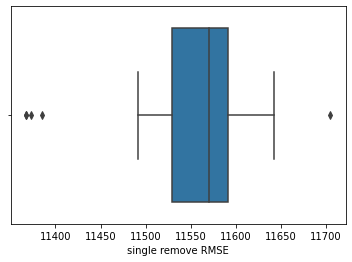

In [ ]:
sns.boxplot(data=pd.DataFrame({"single remove RMSE": rmses}), x="single remove RMSE")
plt.show()

# Zadanie 2c
Imputacja dla dwóch zmiennych

In [ ]:
ntimes = 25 # zamiast 10
rmses_r = [0] * ntimes

np.random.seed(44)
random_states = np.random.randint(1, 100, size=(ntimes, 2))

for i in range(ntimes):
  df_removed_l = df_raw.copy()[["it_seller_rating", "price", "it_quantity"]]

  df_removed_l.loc[df_removed_l.sample(frac=0.1, random_state=random_states[i][0]).index,
                   "it_seller_rating"] = np.nan

  df_removed_l.loc[df_removed_l.sample(frac=0.1, random_state=random_states[i][1]).index,
                   "it_quantity"] = np.nan

  df_imputed_l = pd.DataFrame(imputer.fit_transform(df_removed_l)).astype("int64")

  rmses_r[i] = mean_squared_error(df_raw.it_seller_rating, df_imputed_l.iloc[:, 0], squared=False)

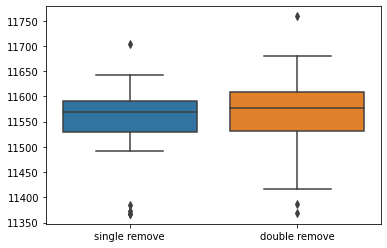

In [ ]:
sns.boxplot(
    data=pd.DataFrame({
        "single remove": rmses,
        "double remove": rmses_r
    })
)
plt.show()

Imputacja dwóch zmiennych nieznacznie zwiększyła błąd, ale znacznie zwiększyła rozrzut danych. Próbka tylko dziesięciu eksperymentów nie była wystarczająca do stwierdzenia tego, jak próbowałem różne ziarna to otrzymywałem sprzeczne ze sobą wyniki. Z tego powodu zdecydowałem się zwiększyć liczbę prób do 25, aby móc coś z tych wyników wyciągnąć.

Próbowałem również KNNImputer, ale od razu miałem problemy z wydajnością, a więc zdecydowałem się użyć IterativeImputera.